Saved summary: fit_qc_plots/fit_summary_by_replicate.csv
Saved 20/50/80 percentile table: fit_qc_plots/percentiles_20_50_80_by_replicate.csv
  replicate  c_max_p20  c_max_med  c_max_p80    A_p20    A_med    A_p80     L_p20     L_med     L_p80
replicate_1  26.925755  41.755878  66.702147 0.003235 0.004716 0.010303 29.000000 29.500000 31.724367
replicate_2  69.869427  79.450149 141.108441 0.006891 0.008498 0.014443 30.000000 44.000000 60.000000
replicate_3  26.116112  61.116450  80.475969 0.001230 0.009433 0.015124 29.000000 29.000000 39.608621
replicate_4  70.531312  91.055251  95.947714 0.018682 0.022204 0.032421 37.829452 60.000000 60.000000
replicate_5  63.896359  98.149794 108.433219 0.005335 0.010586 0.019180 29.000000 29.000000 29.606684
replicate_6  49.718686  59.227040  79.164122 0.006775 0.012728 0.017523 29.000000 32.426457 58.400000
replicate_7  64.578182  93.944450 110.458425 0.008668 0.010353 0.011594 29.000000 30.000000 30.000000


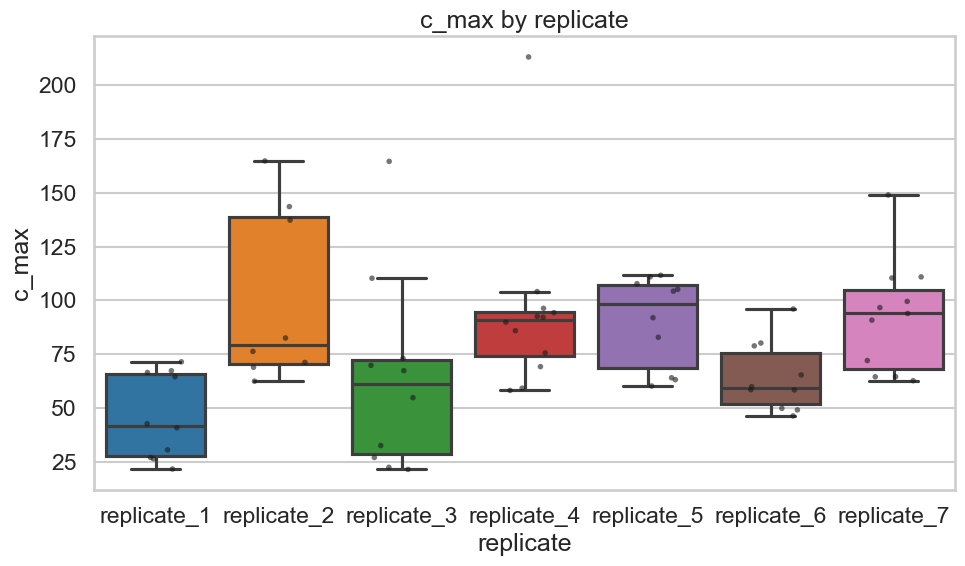

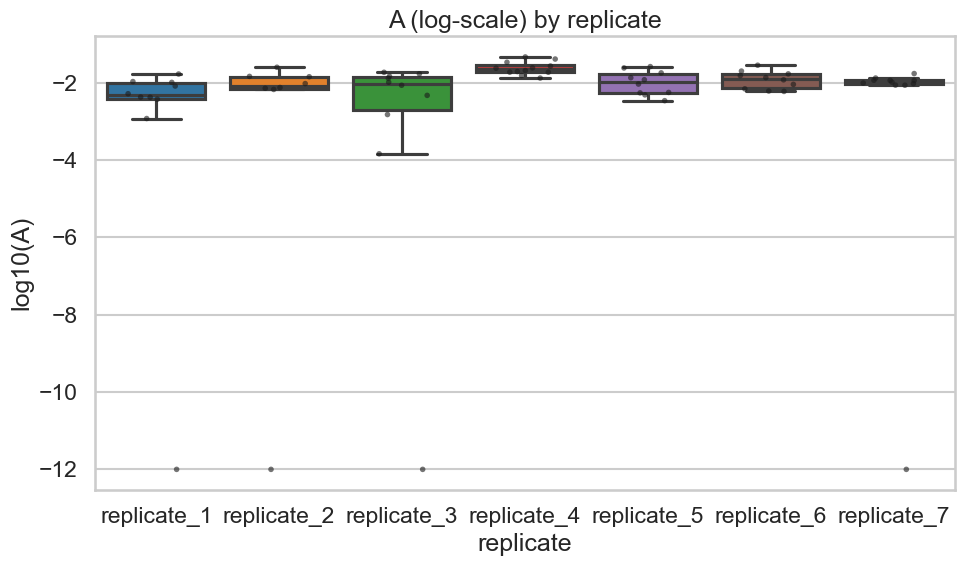

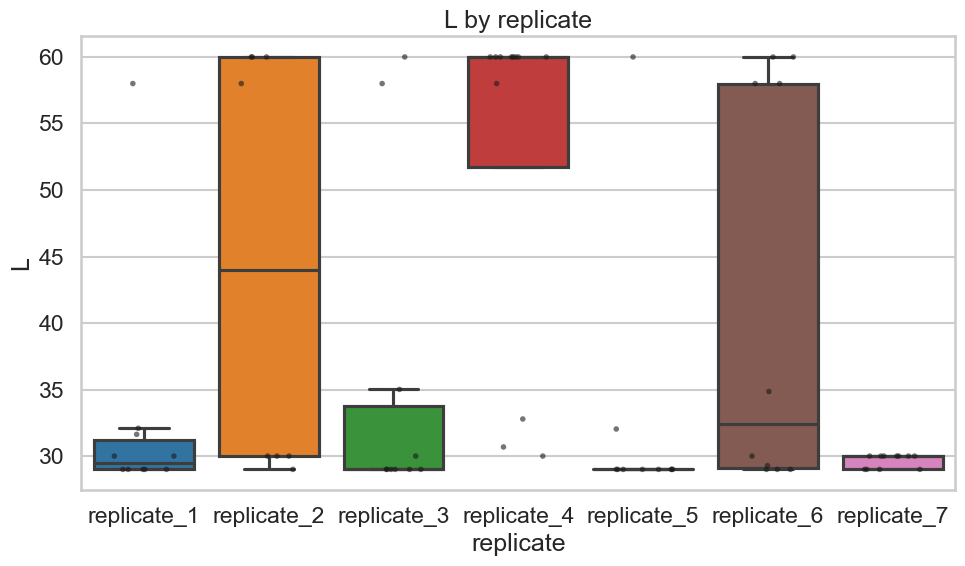

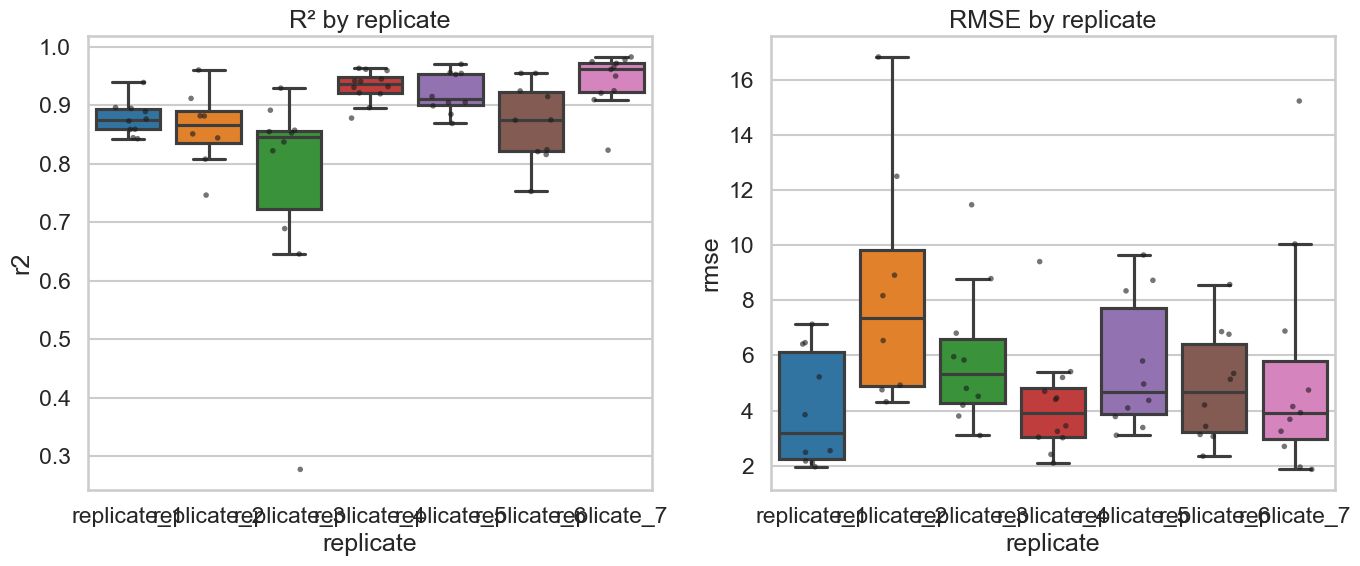

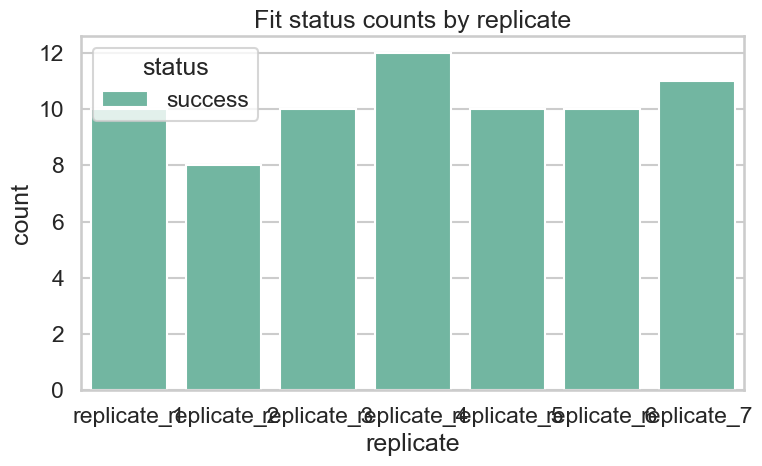

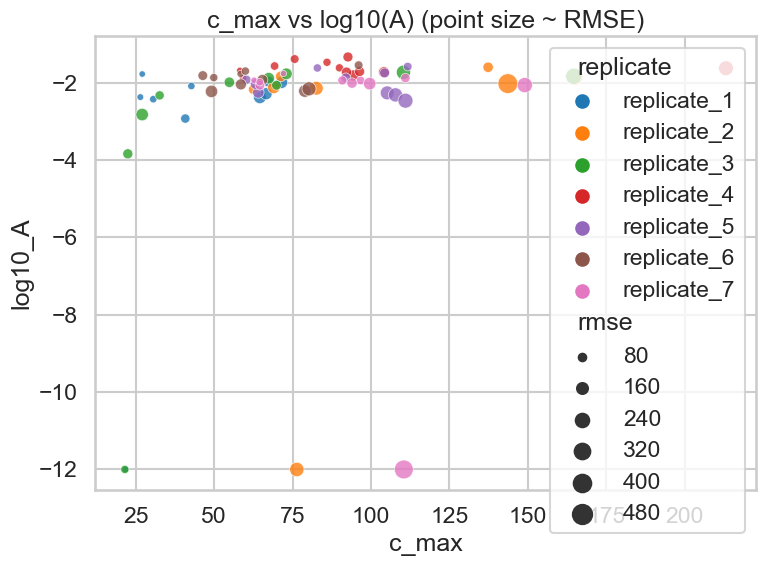

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ---------------- Config ----------------
FITS_CSV = '/Volumes/ScientificData/Users/Giulia(botgiu00)/Papers/bottacin2025/Analysis/Figures/Figures3/3C_hqno_concentration/3C_HQNO_concentration.csv'  # output of your HQNO fitter (no 'offset' column anymore)
OUT_DIR  = Path('fit_qc_plots')
OUT_DIR.mkdir(exist_ok=True, parents=True)

# ---------------- Load & tidy ----------------
df = pd.read_csv(FITS_CSV)

# Expected columns (new fitter w/o 'offset'):
# ['replicate','pos','c_max','L','A','r2','rmse','status']
needed = {'replicate','pos','c_max','L','A','r2','rmse','status'}
missing = needed - set(df.columns)
if missing:
    raise ValueError(f"CSV missing required columns: {sorted(missing)}")

# Keep a copy with all rows
df_all = df.copy()

# Filter to successful fits for parameter analysis
df = df[df['status'] == 'success'].copy()

# Coerce numerics (robust)
for col in ['c_max','L','A','r2','rmse']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Derive safe log versions (avoid <=0)
df['log10_A'] = np.log10(df['A'].where(df['A'] > 0))
df['log10_cmax'] = np.log10(df['c_max'].where(df['c_max'] > 0))

# ---------------- Summary table ----------------
summary = (df.groupby('replicate', dropna=True)
             .agg(
                 n=('pos','count'),
                 cmax_med=('c_max','median'),
                 cmax_iqr=('c_max', lambda s: np.subtract(*np.percentile(s.dropna(), [75,25]))),
                 A_med=('A','median'),
                 A_iqr=('A', lambda s: np.subtract(*np.percentile(s.dropna(), [75,25]))),
                 L_med=('L','median'),
                 r2_med=('r2','median'),
                 rmse_med=('rmse','median')
             )
             .reset_index())
summary.to_csv(OUT_DIR/'fit_summary_by_replicate.csv', index=False)
print("Saved summary:", OUT_DIR/'fit_summary_by_replicate.csv')

# ---------------- NEW: 20th / 50th / 80th percentiles table ----------------
def pct_series(g: pd.DataFrame) -> pd.Series:
    def p(s, q): 
        s = s.dropna()
        return np.nan if s.empty else np.percentile(s, q)
    return pd.Series({
        'c_max_p20': p(g['c_max'], 20), 'c_max_med': p(g['c_max'], 50), 'c_max_p80': p(g['c_max'], 80),
        'A_p20':     p(g['A'], 20),     'A_med':     p(g['A'], 50),     'A_p80':     p(g['A'], 80),
        'L_p20':     p(g['L'], 20),     'L_med':     p(g['L'], 50),     'L_p80':     p(g['L'], 80),
    })

percentiles = df.groupby('replicate', dropna=True).apply(pct_series).reset_index()
percentiles_path = OUT_DIR/'percentiles_20_50_80_by_replicate.csv'
percentiles.to_csv(percentiles_path, index=False)
print("Saved 20/50/80 percentile table:", percentiles_path)
print(percentiles.to_string(index=False))

# ---------------- Plot settings ----------------
sns.set(style='whitegrid', context='talk')
palette = sns.color_palette('tab10', n_colors=df['replicate'].nunique() or 1)

# ---------------- 1) c_max by replicate ----------------
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='replicate', y='c_max', palette=palette, showfliers=False)
sns.stripplot(data=df, x='replicate', y='c_max', color='k', size=4, alpha=0.6, jitter=0.25)
plt.title('c_max by replicate')
plt.tight_layout()
# plt.ylim(0, 100)  # optional cap
plt.savefig(OUT_DIR/'cmax_by_replicate.png', dpi=200)
plt.show()

# ---------------- 2) A by replicate (log scale) ----------------
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='replicate', y='log10_A', palette=palette, showfliers=False)
sns.stripplot(data=df, x='replicate', y='log10_A', color='k', size=4, alpha=0.6, jitter=0.25)
plt.ylabel('log10(A)')
plt.title('A (log-scale) by replicate')
plt.tight_layout()
plt.savefig(OUT_DIR/'A_log_by_replicate.png', dpi=200)
plt.show()

# ---------------- 3) L by replicate ----------------
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='replicate', y='L', palette=palette, showfliers=False)
sns.stripplot(data=df, x='replicate', y='L', color='k', size=4, alpha=0.6, jitter=0.25)
plt.title('L by replicate')
plt.tight_layout()
plt.savefig(OUT_DIR/'L_by_replicate.png', dpi=200)
plt.show()

# ---------------- 4) Fit quality: r2 and rmse ----------------
fig, axes = plt.subplots(1,2, figsize=(14,6))

sns.boxplot(data=df, x='replicate', y='r2', ax=axes[0], palette=palette, showfliers=False)
sns.stripplot(data=df, x='replicate', y='r2', ax=axes[0], color='k', size=4, alpha=0.6, jitter=0.25)
axes[0].set_title('R² by replicate')

sns.boxplot(data=df, x='replicate', y='rmse', ax=axes[1], palette=palette, showfliers=False)
sns.stripplot(data=df, x='replicate', y='rmse', ax=axes[1], color='k', size=4, alpha=0.6, jitter=0.25)
axes[1].set_title('RMSE by replicate')

plt.tight_layout()
plt.savefig(OUT_DIR/'fit_quality_by_replicate.png', dpi=200)
plt.show()

# ---------------- 5) Status counts (QC) ----------------
plt.figure(figsize=(8,5))
status_counts = (df_all
                 .groupby(['replicate','status'])
                 .size()
                 .reset_index(name='count'))
sns.barplot(data=status_counts, x='replicate', y='count', hue='status', palette='Set2')
plt.title('Fit status counts by replicate')
plt.tight_layout()
plt.savefig(OUT_DIR/'status_counts_by_replicate.png', dpi=200)
plt.show()

# ---------------- 6) Parameter correlation (pairplot) ----------------
"""pair_cols = ['c_max','A','L','r2','rmse']
pp = sns.pairplot(df[pair_cols + ['replicate']].dropna(), hue='replicate', corner=True, diag_kind='hist')
pp.fig.suptitle('Parameter relationships', y=1.02)
pp.savefig(OUT_DIR/'pairplot_params.png', dpi=200)
plt.show()"""

# ---------------- 7) c_max vs A (log A), size by RMSE, color by replicate ----------------
plt.figure(figsize=(8,6))
plot_df = df.dropna(subset=['c_max','log10_A'])
sizes = 200 * (plot_df['rmse'] / plot_df['rmse'].quantile(0.75)).clip(0.2, 2.5)
sns.scatterplot(data=plot_df, x='c_max', y='log10_A', hue='replicate', size=sizes,
                palette=palette, sizes=(20,200), alpha=0.8, edgecolor='white', linewidth=0.5)
plt.title('c_max vs log10(A) (point size ~ RMSE)')
plt.tight_layout()
plt.savefig(OUT_DIR/'cmax_vs_logA_scatter.png', dpi=200)
plt.show()


Pooled rows saved to: fit_qc_plots/pooled__replicate_4_replicate_5_replicate_7__rows.csv
Pooled summary saved to: fit_qc_plots/pooled__replicate_4_replicate_5_replicate_7__summary.csv
Pooled percentiles saved to: fit_qc_plots/pooled__replicate_4_replicate_5_replicate_7__percentiles_20_50_80.csv

Pooled summary:
                                    pool  n  cmax_med  cmax_iqr    A_med    A_iqr  L_med   r2_med  rmse_med
replicate_4 + replicate_5 + replicate_7 33 92.186383 35.074096 0.013209 0.011171   30.0 0.940707  4.146504

Pooled percentiles:
                                    pool  c_max_p20  c_max_med  c_max_p80    A_p20    A_med    A_p80  L_p20  L_med  L_p80
replicate_4 + replicate_5 + replicate_7  64.551484  92.186383 106.743564 0.008888 0.013209 0.023942   29.0   30.0   60.0


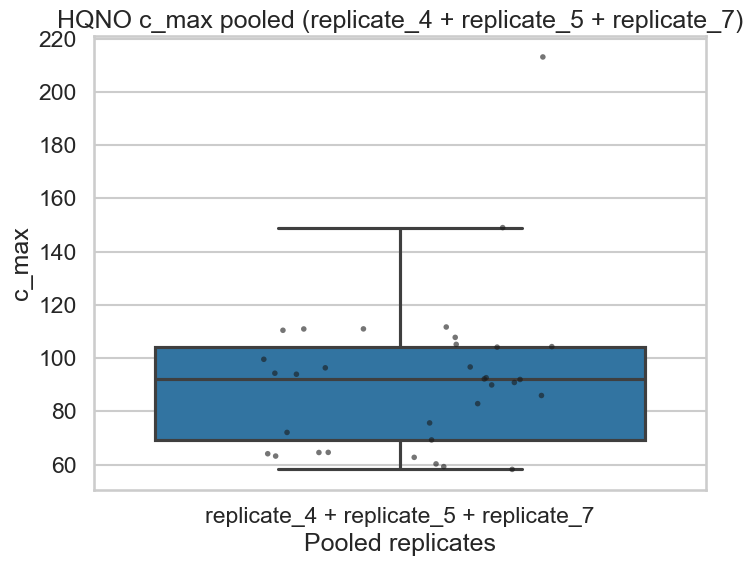

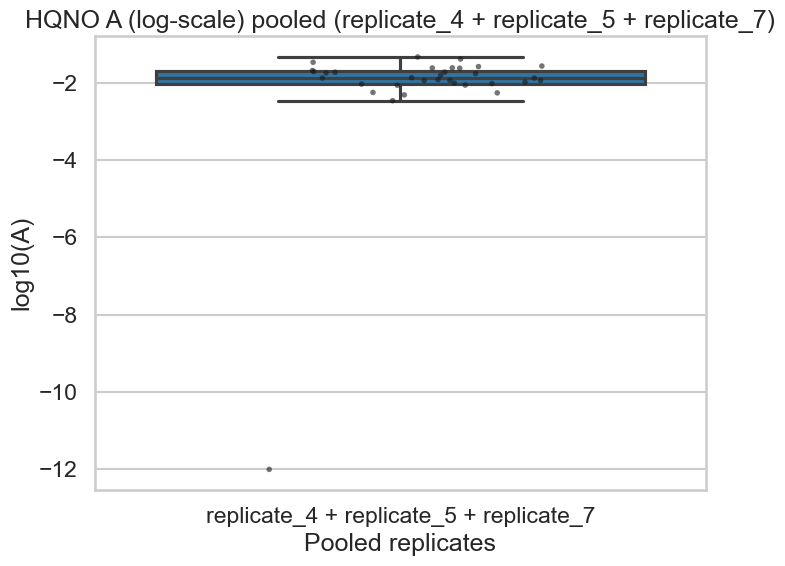

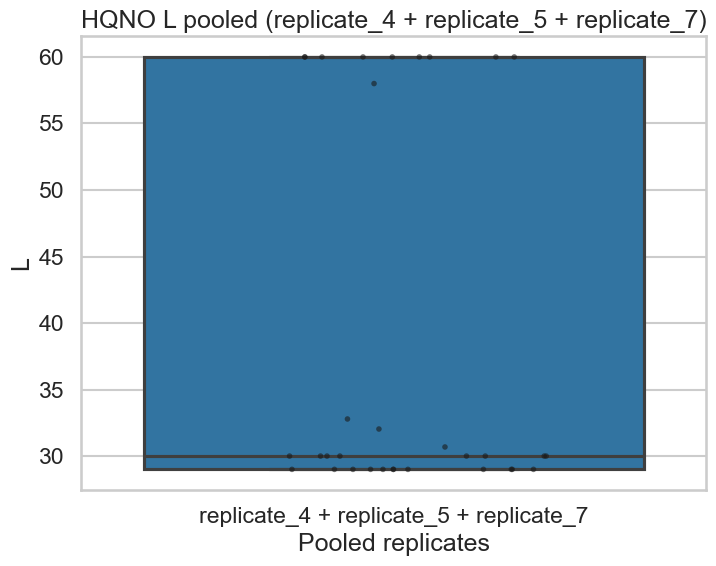

In [6]:
# ========================= EXTRA CELL: pool selected HQNO replicates =========================
# Choose which replicate labels to pool (must match values in df['replicate'])
POOL_REPLICATES = ['replicate_4', 'replicate_5', 'replicate_7']  # <-- EDIT THIS LIST (or set to sorted(df['replicate'].unique()))

# ------------- guardrails -------------
if 'df' not in globals() or 'df_all' not in globals():
    raise RuntimeError("This cell expects the earlier cell to have loaded `df` and `df_all`.")
if not isinstance(POOL_REPLICATES, (list, tuple)) or len(POOL_REPLICATES) == 0:
    raise ValueError("POOL_REPLICATES must be a non-empty list/tuple of replicate labels.")

# ------------- make pooled dataframe -------------
pooled_df = df[df['replicate'].isin(POOL_REPLICATES)].copy()
if pooled_df.empty:
    raise ValueError(f"No rows matched POOL_REPLICATES={POOL_REPLICATES}. "
                     f"Available replicates: {sorted(df['replicate'].unique())}")

# Derive (or re-derive) safe logs for pooled set
pooled_df['log10_A']    = np.log10(pooled_df['A'].where(pooled_df['A'] > 0))
pooled_df['log10_cmax'] = np.log10(pooled_df['c_max'].where(pooled_df['c_max'] > 0))

# ------------- helpers -------------
def _iqr(series: pd.Series):
    s = pd.to_numeric(series, errors='coerce').dropna()
    return np.nan if s.empty else np.subtract(*np.percentile(s, [75, 25]))

def _p(series: pd.Series, q: float):
    s = pd.to_numeric(series, errors='coerce').dropna()
    return np.nan if s.empty else np.percentile(s, q)

# ------------- pooled summaries -------------
pool_label = " + ".join(map(str, POOL_REPLICATES))

pooled_summary = (
    pooled_df
      .assign(pool=pool_label)
      .groupby('pool', dropna=False)
      .agg(
          n=('pos','count'),
          cmax_med=('c_max','median'),
          cmax_iqr=('c_max', _iqr),
          A_med=('A','median'),
          A_iqr=('A', _iqr),
          L_med=('L','median'),
          r2_med=('r2','median'),
          rmse_med=('rmse','median')
      )
      .reset_index()
)

pooled_percentiles = (
    pooled_df
      .assign(pool=pool_label)
      .groupby('pool', dropna=False)
      .agg(
          c_max_p20=('c_max', lambda s: _p(s, 20)),
          c_max_med=('c_max', lambda s: _p(s, 50)),
          c_max_p80=('c_max', lambda s: _p(s, 80)),
          A_p20    =('A',     lambda s: _p(s, 20)),
          A_med    =('A',     lambda s: _p(s, 50)),
          A_p80    =('A',     lambda s: _p(s, 80)),
          L_p20    =('L',     lambda s: _p(s, 20)),
          L_med    =('L',     lambda s: _p(s, 50)),
          L_p80    =('L',     lambda s: _p(s, 80)),
      )
      .reset_index()
)

# ------------- save outputs -------------
pool_stub = f"pooled__{'_'.join(map(str, POOL_REPLICATES))}"
pooled_raw_path         = OUT_DIR / f"{pool_stub}__rows.csv"
pooled_summary_path     = OUT_DIR / f"{pool_stub}__summary.csv"
pooled_percentiles_path = OUT_DIR / f"{pool_stub}__percentiles_20_50_80.csv"

pooled_df.to_csv(pooled_raw_path, index=False)
pooled_summary.to_csv(pooled_summary_path, index=False)
pooled_percentiles.to_csv(pooled_percentiles_path, index=False)

print("Pooled rows saved to:", pooled_raw_path)
print("Pooled summary saved to:", pooled_summary_path)
print("Pooled percentiles saved to:", pooled_percentiles_path)
print("\nPooled summary:\n", pooled_summary.to_string(index=False))
print("\nPooled percentiles:\n", pooled_percentiles.to_string(index=False))

# ------------- pooled QC plots -------------
sns.set(style='whitegrid', context='talk')
pool_palette = sns.color_palette('tab10', n_colors=1)

def _can_plot_local(_df, ycol):
    return (not _df.empty) and (pd.to_numeric(_df[ycol], errors='coerce').notna().any())

# Box/strip for c_max (pooled only)
if _can_plot_local(pooled_df, 'c_max'):
    plt.figure(figsize=(7.5,6))
    sns.boxplot(data=pooled_df.assign(pool=pool_label), x='pool', y='c_max',
                palette=pool_palette, showfliers=False)
    sns.stripplot(data=pooled_df.assign(pool=pool_label), x='pool', y='c_max',
                  color='k', size=4, alpha=0.6, jitter=0.25)
    plt.xlabel('Pooled replicates')
    plt.title(f'HQNO c_max pooled ({pool_label})')
    plt.tight_layout()
    plt.savefig(OUT_DIR / f"{pool_stub}__cmax.png", dpi=200)
    plt.show()

# Box/strip for A (log10 proxy)
if _can_plot_local(pooled_df, 'log10_A'):
    plt.figure(figsize=(7.5,6))
    sns.boxplot(data=pooled_df.assign(pool=pool_label), x='pool', y='log10_A',
                palette=pool_palette, showfliers=False)
    sns.stripplot(data=pooled_df.assign(pool=pool_label), x='pool', y='log10_A',
                  color='k', size=4, alpha=0.6, jitter=0.25)
    plt.ylabel('log10(A)')
    plt.xlabel('Pooled replicates')
    plt.title(f'HQNO A (log-scale) pooled ({pool_label})')
    plt.tight_layout()
    plt.savefig(OUT_DIR / f"{pool_stub}__A_log.png", dpi=200)
    plt.show()

# Box/strip for L (pooled)
if _can_plot_local(pooled_df, 'L'):
    plt.figure(figsize=(7.5,6))
    sns.boxplot(data=pooled_df.assign(pool=pool_label), x='pool', y='L',
                palette=pool_palette, showfliers=False)
    sns.stripplot(data=pooled_df.assign(pool=pool_label), x='pool', y='L',
                  color='k', size=4, alpha=0.6, jitter=0.25)
    plt.xlabel('Pooled replicates')
    plt.title(f'HQNO L pooled ({pool_label})')
    plt.tight_layout()
    plt.savefig(OUT_DIR / f"{pool_stub}__L.png", dpi=200)
    plt.show()


Saved figure to: fit_qc_plots/curves_band_L_abs.png


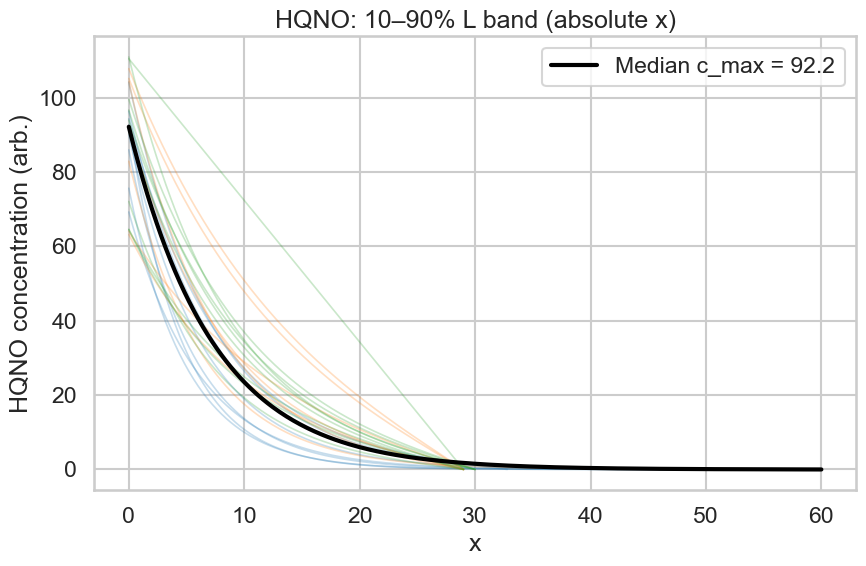

In [18]:
# ===================== EXTRA CELL (HQNO): percentile-banded curves, highlight median =====================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from typing import Optional, List

def _sinh_curve(c_max: float, sA: float, L: float, x: np.ndarray) -> np.ndarray:
    """
    c(x) = c_max * sinh(sA*(L - x)) / sinh(sA*L)
    Uses linear limit when sA*L is very small to avoid numerical issues.
    """
    sA = float(sA); L = float(L); c_max = float(c_max)
    if not np.isfinite(c_max) or not np.isfinite(sA) or not np.isfinite(L) or L <= 0:
        return np.full_like(x, np.nan, dtype=float)
    z = sA * L
    if abs(z) < 1e-6:
        return c_max * (L - x) / max(L, 1e-12)
    return c_max * np.sinh(sA * (L - x)) / np.sinh(z)

def plot_hqno_curves_between_percentiles(
    df: pd.DataFrame,
    metric: str = "c_max",
    p_low: float = 20.0,
    p_high: float = 80.0,
    replicates_to_include: Optional[List[str]] = None,
    normalize_x: bool = True,
    n_points: int = 300,
    title: Optional[str] = None,
    out_path: Optional[str] = None
):
    """
    Plot HQNO curves for rows whose `metric` lies in [p_low, p_high] percentiles.
    Highlights the median curve (by the same metric) in black.

    Requires columns: ['c_max','A','L','replicate'].
    Uses sA = sqrt(A). Rows with A<0 are dropped.
    """
    needed = {'c_max','A','L','replicate'}
    missing = needed - set(df.columns)
    if missing:
        raise KeyError(f"df missing required columns: {sorted(missing)}")
    work = df.copy()

    # Optional replicate filter
    if replicates_to_include is not None:
        work = work[work['replicate'].isin(replicates_to_include)]

    # Ensure numeric & valid parameters; drop A<0 (sqrt undefined)
    for col in ['c_max','A','L', metric]:
        work[col] = pd.to_numeric(work[col], errors='coerce')
    work = work[np.isfinite(work['c_max']) & np.isfinite(work['A']) & np.isfinite(work['L']) & (work['L'] > 0)]
    work = work[work['A'] >= 0]

    if work.empty:
        raise ValueError("No valid rows after filtering (check replicates/columns and A>=0).")

    # Percentile band
    lo = np.nanpercentile(work[metric], p_low)
    hi = np.nanpercentile(work[metric], p_high)
    sel = work[(work[metric] >= lo) & (work[metric] <= hi)].copy()
    if sel.empty:
        raise ValueError(f"No rows between the {p_low:.1f}th and {p_high:.1f}th percentiles of '{metric}'.")

    # Median within band
    med_val = np.nanpercentile(sel[metric], 50)
    sel['__abs_diff__'] = np.abs(sel[metric] - med_val)
    med_row = sel.loc[sel['__abs_diff__'].idxmin()]

    # Plot
    sns.set(style='whitegrid', context='talk')
    fig, ax = plt.subplots(figsize=(9, 6))

    reps = sel['replicate'].astype(str).unique()
    pal = sns.color_palette('tab10', n_colors=max(1, len(reps)))
    color_map = {r: pal[i % len(pal)] for i, r in enumerate(reps)}

    # Background curves
    for _, r in sel.iterrows():
        L = float(r['L'])
        sA = float(np.sqrt(r['A']))
        cM = float(r['c_max'])
        if normalize_x:
            xi = np.linspace(0.0, 1.0, n_points)
            x = xi * L
            y = _sinh_curve(cM, sA, L, x)
            ax.plot(xi, y, lw=1.2, alpha=0.25, color=color_map[str(r['replicate'])])
        else:
            x = np.linspace(0.0, L, n_points)
            y = _sinh_curve(cM, sA, L, x)
            ax.plot(x, y, lw=1.2, alpha=0.25, color=color_map[str(r['replicate'])])

    # Median curve
    Lm = float(med_row['L'])
    sAm = float(np.sqrt(med_row['A']))
    cMm = float(med_row['c_max'])
    if normalize_x:
        xi = np.linspace(0.0, 1.0, n_points)
        xm = xi * Lm
        ym = _sinh_curve(cMm, sAm, Lm, xm)
        ax.plot(xi, ym, lw=3.0, color='black', label=f"Median {metric} = {med_val:.3g}")
        ax.set_xlabel("x / L")
    else:
        xm = np.linspace(0.0, Lm, n_points)
        ym = _sinh_curve(cMm, sAm, Lm, xm)
        ax.plot(xm, ym, lw=3.0, color='black', label=f"Median {metric} = {med_val:.3g}")
        ax.set_xlabel("x")

    ax.set_ylabel("HQNO concentration (arb.)")
    ttl = title or f"HQNO curves between {p_low:.0f}–{p_high:.0f} percentile of '{metric}'"
    ax.set_title(ttl)
    ax.legend(loc='best')
    plt.tight_layout()
    if out_path is not None:
        plt.savefig(out_path, dpi=200)
        print("Saved figure to:", out_path)
    plt.show()

# ---------------- Example call (HQNO) ----------------
plot_hqno_curves_between_percentiles(df, metric='c_max', p_low=10, p_high=90,
                                replicates_to_include=['replicate_4', 'replicate_5', 'replicate_7'],
                                 normalize_x=False,
                                 title="HQNO: 10–90% L band (absolute x)",
                                 out_path=OUT_DIR / 'curves_band_L_abs.png')


In [19]:
# ===================== HQNO: simple quantile summary by replicate =====================
import pandas as pd
import numpy as np
from pathlib import Path

def summarize_hqno_quantiles(
    df: pd.DataFrame,
    reps=None,                                 # e.g. ['rep1','rep2'] or None for all
    out_dir='fit_qc_plots',
    csv_prefix='HQNO_quantiles'
):
    """
    Compute median, 25/75 and 2.5/97.5 percentiles for HQNO fit params
    per replicate, plus a pooled row. Saves CSVs and prints summaries.

    Expects columns: ['replicate','pos','c_max','L','A','r2','rmse','status']
    """
    needed = {'replicate','pos','c_max','L','A','r2','rmse','status'}
    missing = needed - set(df.columns)
    if missing:
        raise ValueError(f"Input df missing columns: {sorted(missing)}")

    # Keep successful fits only
    work = df[df['status'].astype(str) == 'success'].copy()
    if reps is not None:
        work = work[work['replicate'].isin(reps)]
        pool_label = " + ".join(map(str, reps)) if len(reps) else "NONE"
    else:
        pool_label = "ALL"

    if work.empty:
        raise ValueError("No rows after filtering (check `status` and `reps`).")

    # Ensure numeric for params
    params = ['c_max','A','L','r2','rmse']
    for c in params:
        work[c] = pd.to_numeric(work[c], errors='coerce')
    work = work.dropna(subset=params)
    if work.empty:
        raise ValueError("No valid numeric rows after coercion.")

    # Helper
    def q(series, p):
        s = pd.to_numeric(series, errors='coerce').dropna()
        return np.nan if s.empty else np.percentile(s, p)

    # Per-replicate table
    rows = []
    for rep, g in work.groupby('replicate', dropna=False):
        row = {'replicate': rep, 'n': int(g.shape[0])}
        for p in params:
            row[f'{p}_med']   = q(g[p], 50)
            row[f'{p}_q25']   = q(g[p], 25)
            row[f'{p}_q75']   = q(g[p], 75)
            row[f'{p}_q2p5']  = q(g[p], 2.5)
            row[f'{p}_q97p5'] = q(g[p], 97.5)
        rows.append(row)
    by_rep = pd.DataFrame(rows).sort_values('replicate').reset_index(drop=True)

    # Pooled row across selected replicates
    pool = {'replicate': f'POOL({pool_label})', 'n': int(work.shape[0])}
    for p in params:
        pool[f'{p}_med']   = q(work[p], 50)
        pool[f'{p}_q25']   = q(work[p], 25)
        pool[f'{p}_q75']   = q(work[p], 75)
        pool[f'{p}_q2p5']  = q(work[p], 2.5)
        pool[f'{p}_q97p5'] = q(work[p], 97.5)
    pooled = pd.DataFrame([pool])

    # Save + print
    out = Path(out_dir); out.mkdir(parents=True, exist_ok=True)
    by_rep_path  = out / f'{csv_prefix}__by_replicate.csv'
    pooled_path  = out / f'{csv_prefix}__pooled.csv'
    by_rep.to_csv(by_rep_path, index=False)
    pooled.to_csv(pooled_path, index=False)

    # Clean print
    pd.set_option('display.max_columns', None)
    print(f"\nHQNO quantiles by replicate (saved -> {by_rep_path}):")
    print(by_rep.to_string(index=False))
    print(f"\nHQNO quantiles pooled over {pool_label} (saved -> {pooled_path}):")
    print(pooled.to_string(index=False))

    return by_rep, pooled

# ---------------- Example usage ----------------
# 1) All replicates:
# summarize_hqno_quantiles(df)

# 2) Only selected replicates:
summarize_hqno_quantiles(df, reps=['replicate_4', 'replicate_5', 'replicate_7'])



HQNO quantiles by replicate (saved -> fit_qc_plots/HQNO_quantiles__by_replicate.csv):
  replicate  n  c_max_med  c_max_q25  c_max_q75  c_max_q2p5  c_max_q97p5    A_med    A_q25    A_q75   A_q2p5  A_q97p5  L_med     L_q25  L_q75   L_q2p5   L_q97p5   r2_med   r2_q25   r2_q75  r2_q2p5  r2_q97p5  rmse_med  rmse_q25  rmse_q75  rmse_q2p5  rmse_q97p5
replicate_4 12  91.055251  74.049531  94.833462   58.482288   183.176244 0.022204 0.018735 0.028687 0.013790 0.044852   60.0 51.696704   60.0 30.18799 60.000000 0.936233 0.920641 0.948277 0.882829  0.962546  3.924205  3.028781  4.823010   2.180147    8.307576
replicate_5 10  98.149794  68.777079 107.137770   60.913943   111.533263 0.010586 0.005494 0.016831 0.003751 0.025634   29.0 29.000000   29.0 29.00000 53.707519 0.909885 0.900292 0.953863 0.872301  0.966762  4.666761  3.860109  7.708081   3.166085    9.439354
replicate_7 11  93.944450  68.329428 105.009280   63.169874   139.515481 0.010353 0.009079 0.011531 0.002151 0.016231   30.0 29.00000

(     replicate   n  c_max_med  c_max_q25   c_max_q75  c_max_q2p5  c_max_q97p5   
 0  replicate_4  12  91.055251  74.049531   94.833462   58.482288   183.176244  \
 1  replicate_5  10  98.149794  68.777079  107.137770   60.913943   111.533263   
 2  replicate_7  11  93.944450  68.329428  105.009280   63.169874   139.515481   
 
       A_med     A_q25     A_q75    A_q2p5   A_q97p5  L_med      L_q25  L_q75   
 0  0.022204  0.018735  0.028687  0.013790  0.044852   60.0  51.696704   60.0  \
 1  0.010586  0.005494  0.016831  0.003751  0.025634   29.0  29.000000   29.0   
 2  0.010353  0.009079  0.011531  0.002151  0.016231   30.0  29.000000   30.0   
 
      L_q2p5    L_q97p5    r2_med    r2_q25    r2_q75   r2_q2p5  r2_q97p5   
 0  30.18799  60.000000  0.936233  0.920641  0.948277  0.882829  0.962546  \
 1  29.00000  53.707519  0.909885  0.900292  0.953863  0.872301  0.966762   
 2  29.00000  30.000000  0.961157  0.922637  0.972864  0.844679  0.981291   
 
    rmse_med  rmse_q25  rmse_q75  